In [1]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Make a conversational chatbot using a Sequence-to-sequence framework

### read in data and do some cleaning

In [2]:
batch_size = 64  # Batch size for training.
epochs = 800  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 900000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '../Downloads/cornell/movie_lines.txt'
with open(data_path, 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.read().split('\n')
line_dict = {}
line_dict[0] = []
line_dict[1] = []
input_characters = set()
target_characters = set()
movie_lines, line_numbers, scene_ids, movies = [], [], [], []
for i, line in enumerate(lines):
    # print(line)
    j = i % 2
    splitted = line.split('+++$+++')
    # print((splitted))
    # input('stopped')
    if len(splitted) == 5:
        movie_lines.append(splitted[-1].strip().lower())
        line_numbers.append(splitted[0].strip())
        scene_ids.append(splitted[1].strip())
        movies.append(splitted[2].strip())

script_df = pd.DataFrame({'movie_line': movie_lines, 
                          'line_number': line_numbers,
                          'scene_id': scene_ids,
                          'movie_id': movies})
    

"'    \nif j == 1:\n    movie_line = '\t' + movie_line.lower() + '\n'\n    for char in movie_line:\n        if char not in target_characters:\n            target_characters.add(char)\nelse:\n    for char in movie_line:\n        if char not in input_characters:\n            input_characters.add(char)\nline_dict[j].append(movie_line)"

In [3]:
script_df['line_number'] = script_df['line_number'].map(lambda x: int(x.replace('L', '')))
script_df = script_df.sort_values(by = ['movie_id', 'line_number' ])
script_df = script_df[script_df['movie_line'].map(lambda x: len(x) < 60)]
script_df.head(60)
print(len(script_df))

213472


In [5]:
input_comments, output_comments = [], []
for i in range(1, len(script_df)):
    row = script_df.iloc[i]
    row0 = script_df.iloc[i-1]
    if ((row['movie_id'] == row0['movie_id']) &
        # (row['scene_id'] == row0['scene_id']) &
        (row['line_number'] == (row0['line_number']+1))):
            input_comments.append(row0['movie_line'])
            output_comments.append(row['movie_line'])
    if i % 1000 == 0:
        print(i)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [ ]:
### Now we have a simple DF with inputs and outputs

In [7]:
df = pd.DataFrame({'input_comment': input_comments, 'output_comment': output_comments})# [0:200000]
df.to_csv('movie_line_training.csv')
print(len(df))
df.head()
# df[df['input_comment'] == 'They do to!']

129495


,input_comment,output_comment
0,did you change your hair?,no.
1,no.,you might wanna think about it
2,it was a bratwurst. i was eating lunch.,with the teeth of your zipper?
3,with the teeth of your zipper?,you the new guy?
4,you the new guy?,so they tell me...


In [9]:
# remoe any that contain our termination characters
df = df[~df['input_comment'].str.contains('~')]
df = df[~df['input_comment'].str.contains('`')]
df = df[~df['output_comment'].str.contains('~')]
df = df[~df['output_comment'].str.contains('`')]
df = df[df['input_comment'] != '[removed]']
df = df[df['input_comment'] != '[deleted]']
df = df[df['output_comment'] != '[removed]']
df = df[df['output_comment'] != '[deleted]']
df[['input_comment', 'output_comment']].to_csv('movie_line_training.csv')
input_texts = list(df['input_comment'])
target_texts = list(df['output_comment'])

### Vectorize at the character level

In [10]:
input_characters = set()
new_targets = []
target_characters = set()
for i in input_texts:
    for char in i:
        if char not in input_characters:
            input_characters.add(char)
for j in target_texts:
    target_text = '~' + j + '`'
    new_targets.append(target_text)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)
target_texts = new_targets

In [11]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 129458
Number of unique input tokens: 64
Number of unique output tokens: 64
Max sequence length for inputs: 59
Max sequence length for outputs: 61


In [12]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [13]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):

        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

## Build and Train the model

In [ ]:
epochs = 200
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
a = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.05)
# Save model
model.save('movie_line_chatbot.h5')


Train on 122985 samples, validate on 6473 samples
Epoch 1/200
122985/122985 [==============================] - 600s 5ms/step - loss: 0.8856 - val_loss: 0.7184
Epoch 2/200
122985/122985 [==============================] - 583s 5ms/step - loss: 0.6872 - val_loss: 0.6437
Epoch 3/200
122985/122985 [==============================] - 677s 6ms/step - loss: 0.6374 - val_loss: 0.6118
Epoch 4/200
122985/122985 [==============================] - 635s 5ms/step - loss: 0.6121 - val_loss: 0.5962
Epoch 5/200
122985/122985 [==============================] - 626s 5ms/step - loss: 0.5972 - val_loss: 0.5868
Epoch 6/200
122985/122985 [==============================] - 649s 5ms/step - loss: 0.5854 - val_loss: 0.5778
Epoch 7/200
122985/122985 [==============================] - 663s 5ms/step - loss: 0.5760 - val_loss: 0.5724
Epoch 8/200
122985/122985 [==============================] - 665s 5ms/step - loss: 0.5686 - val_loss: 0.5679
Epoch 9/200
122985/122985 [==============================] - 638s 5ms/step - l

122985/122985 [==============================] - 722s 6ms/step - loss: 0.4899 - val_loss: 0.5683
Epoch 76/200
122985/122985 [==============================] - 647s 5ms/step - loss: 0.4895 - val_loss: 0.5682
Epoch 77/200
122985/122985 [==============================] - 629s 5ms/step - loss: 0.4893 - val_loss: 0.5686
Epoch 78/200
122985/122985 [==============================] - 603s 5ms/step - loss: 0.4889 - val_loss: 0.5685
Epoch 79/200
122985/122985 [==============================] - 605s 5ms/step - loss: 0.4886 - val_loss: 0.5693
Epoch 80/200
122985/122985 [==============================] - 631s 5ms/step - loss: 0.4884 - val_loss: 0.5703
Epoch 81/200
122985/122985 [==============================] - 638s 5ms/step - loss: 0.4881 - val_loss: 0.5698
Epoch 82/200
122985/122985 [==============================] - 612s 5ms/step - loss: 0.4879 - val_loss: 0.5698
Epoch 83/200
122985/122985 [==============================] - 606s 5ms/step - loss: 0.4875 - val_loss: 0.5712
Epoch 84/200
122985/122

### Save some important parameters and the model 

In [15]:
import pickle

out_dict = {'input_token_index': input_token_index,
            'target_token_index': target_token_index,
            'num_encoder_tokens': num_encoder_tokens,
            'num_decoder_tokens': num_decoder_tokens,
            'max_encoder_seq_length': max_encoder_seq_length,
            'max_decoder_seq_length': max_decoder_seq_length,
            # 'encoder_inputs': encoder_inputs, check
            # 'encoder_states': encoder_states,
            'latent_dim': latent_dim}
model_name = 'movieline_chatbot_model_v1.1'
model.save(f'{model_name}.h5')
pickle.dump(out_dict, open(f'{model_name}_model_dict.pickle', 'wb'))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


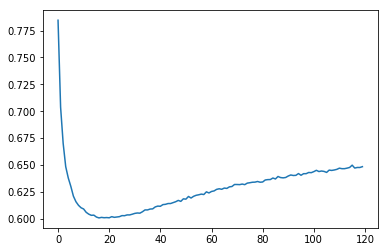

In [16]:

plt.plot(a.history['val_loss'])

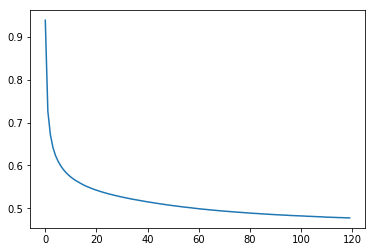

In [17]:
plt.plot(a.history['loss'])

In [18]:
# Next: inference mode (sampling).
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [19]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['~']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '`' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


### Let's see how it does

In [20]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: did you change your hair?
Decoded sentence: yes.`
-
Input sentence: no.
Decoded sentence: what do you mean?`
-
Input sentence: it was a bratwurst.  i was eating lunch.
Decoded sentence: well, i don't know what to say.`
-
Input sentence: with the teeth of your zipper?
Decoded sentence: yeah.`
-
Input sentence: you the new guy?
Decoded sentence: i don't know.`
-
Input sentence: so they tell me...
Decoded sentence: so what do you want?`
-
Input sentence: c'mon.  i'm supposed to give you the tour.
Decoded sentence: what are you doing here?`
-
Input sentence: so -- which dakota you from?
Decoded sentence: so you got a lot of control?`
-
Input sentence: north, actually.  how'd you   ?
Decoded sentence: i was a lot of contestion.`
-
Input sentence: how many people were in your old school?
Decoded sentence: for me.  i was afraid of the car.`
-
Input sentence: thirty-two.
Decoded sentence: you don't know what to do.`
-
Input sentence: get out!
Decoded sentence: i want to go wi

-
Input sentence: hey.  great show, huh?
Decoded sentence: shhh... you want to talk to him?`
-
Input sentence: 
Decoded sentence: `


In [ ]:
# For checkinig out experiment results

In [1]:
# pickle.dump(a.history, open(f'{model_name}_training.pickle', 'wb'))

In [ ]:
dum_input_data = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
for t, char in enumerate("Says who?"):
        dum_input_data[0, t, input_token_index[char]] = 1.